# Installing and importing packages and reading in the data

In [1]:
!pip install awswrangler
!pip install torch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 8.2 MB/s eta 0:00:0000:01
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 85.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 16.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━

  Preparing metadata (pyproject.toml) ... done
  Created wheel for lit: filename=lit-16.0.6-py3-none-any.whl size=93583 sha256=9e93fb81c941cf914338caa98589a917ac7dfd9d157aef28141ca549de75eda3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/14/f9/07/bb2308587bc2f57158f905a2325f6a89a2befa7437b2d7e137
Successfully built lit


In [2]:
import pandas as pd
import numpy as np
import awswrangler as wr
import torch
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import boto3
import io
import pickle
import re

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', None)

In [44]:
df = wr.s3.read_csv('s3://dsp-data-vq22301/final_dataset_with_cap.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/awswrangler/s3/_read_text_core.py:112: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = parser_func(f, **pandas_kwargs)


In [45]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Setting up Variables...

In [33]:
glossary = {
    'CAPEI': {'Ratio': 'Shillers Cyclically Adjusted P/E Ratio', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to 5-year moving average of Net Income'},
    'bm': {'Ratio': 'Book/Market', 'Category': 'Valuation', 'Formula': 'Book Value of Equity as a fraction of Market Value of Equity'},
    'evm': {'Ratio': 'Enterprise Value Multiple', 'Category': 'Valuation', 'Formula': 'Multiple of Enterprise Value to EBITDA'},
    'pe_op_basic': {'Ratio': 'Price/Operating Earnings (Basic, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Basic)'},
    'pe_op_dil': {'Ratio': 'Price/Operating Earnings (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Diluted)'},
    'pe_exi': {'Ratio': 'P/E (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted)'},
    'pe_inc': {'Ratio': 'P/E (Diluted, Incl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, incl. Extraordinary Items (diluted)'},
    'ps': {'Ratio': 'Price/Sales', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Sales'},
    'pcf': {'Ratio': 'Price/Cash flow', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Net Cash Flow from Operating Activities'},
    'dpr': {'Ratio': 'Dividend Payout Ratio', 'Category': 'Valuation', 'Formula': 'Dividends as a fraction of Income Before Extra. Items'},
    'npm': {'Ratio': 'Net Profit Margin', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of Sales'},
    'opmbd': {'Ratio': 'Operating Profit Margin Before Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of Sales'},
    'opmad': {'Ratio': 'Operating Profit Margin After Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of Sales'},
    'gpm': {'Ratio': 'Gross Profit Margin', 'Category': 'Profitability', 'Formula': 'Gross Profit as a fraction of Sales'},
    'ptpm': {'Ratio': 'Pre-tax Profit Margin', 'Category': 'Profitability', 'Formula': 'Pretax Income as a fraction of Sales'},
    'cfm': {'Ratio': 'Cash Flow Margin', 'Category': 'Financial Soundness', 'Formula': 'Income before Extraordinary Items and Depreciation as a fraction of Sales'},
    'roa': {'Ratio': 'Return on Assets', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of average TotalAssets based on most recent two periods'},
    'roe': {'Ratio': 'Return on Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average Book Equity based on most recent two periods, where Book Equity is defined as the sum of Total Parent Stockholders Equity and Deferred Taxes and Investment Tax Credit'},
    'roce': {'Ratio': 'Return on Capital Employed', 'Category': 'Profitability', 'Formula': 'Earnings Before Interest and Taxes as a fraction of average Capital Employed based on most recent two periods, where Capital Employed is the sum of Debt in Long-term and Current Liabilities and Common/Ordinary Equity'},
    'efftax': {'Ratio': 'Effective Tax Rate', 'Category': 'Profitability', 'Formula': 'Income Tax as a fraction of Pretax Income'},
    'aftret_eq': {'Ratio': 'After-tax Return on Average Common Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Common Equity based on most recent two periods'},
    'aftret_invcapx': {'Ratio': 'After-tax Return on Invested Capital', 'Category': 'Profitability', 'Formula': 'Net Income plus Interest Expenses as a fraction of Invested Capital'},
    'aftret_equity': {'Ratio': 'After-tax Return on Total Stockholders’ Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Total Shareholders’ Equity based on most recent two periods'},
    'pretret_noa': {'Ratio': 'Pre-tax return on Net Operating Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Net Operating Assets (NOA) based on most recent two periods, where NOA is defined as the sum of Property Plant and Equipment and Current Assets minus Current Liabilities'},
    'pretret_earnat': {'Ratio': 'Pre-tax Return on Total Earning Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Total Earnings Assets (TEA) based on most recent two periods, where TEA is defined as the sum of Property Plant and Equipment and Current Assets'},
    'GProf': {'Ratio': 'Gross Profit/Total Assets', 'Category': 'Profitability', 'Formula': 'Gross Profitability as a fraction of Total Assets'},
    'equity_invcap': {'Ratio': 'Common Equity/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Common Equity as a fraction of Invested Capital'},
    'debt_invcap': {'Ratio': 'Long-term Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Long-term Debt as a fraction of Invested Capital'},
    'totdebt_invcap': {'Ratio': 'Total Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Total Debt (Long-term and Current) as a fraction of Invested Capital'},
    'capital_ratio': {'Ratio': 'Capitalization Ratio', 'Category': 'Capitalisation', 'Formula': 'Total Long-term Debt as a fraction of the sum of Total Long-term Debt, Common/Ordinary Equity and Preferred Stock'},
    'int_debt': {'Ratio': 'Interest/Average Long-term Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Long-term debt based on most recent two periods'},
    'int_totdebt': {'Ratio': 'Interest/Average Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Total Debt based on most recent two periods'},
    'cash_lt': {'Ratio': 'Cash Balance/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Cash Balance as a fraction of Total Liabilities'},
    'invt_act': {'Ratio': 'Inventory/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Inventories as a fraction of Current Assets'},
    'rect_act': {'Ratio': 'Receivables/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Accounts Receivables as a fraction of Current Assets'},
    'debt_at': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Liabilities as a fraction of Total Assets'},
    'debt_ebitda': {'Ratio': 'debt_ebitda', 'Category': 'Financial Soundness', 'Formula': 'Gross Debt as a fraction of EBITDA'},
    'short_debt': {'Ratio': 'Short-Term Debt/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Short-term Debt as a fraction of Total Debt'},
    'curr_debt': {'Ratio': 'Current Liabilities/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Current Liabilities as a fraction of Total Liabilities'},
    'lt_debt': {'Ratio': 'Long-term Debt/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Long-term Debt as a fraction of Total Liabilities'},
    'profit_lct': {'Ratio': 'Profit Before Depreciation/Current Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Operating Income before D&A as a fraction of Current Liabilities'},
    'ocf_lct': {'Ratio': 'Operating CF/Current Liabilities', 'Category': 'Financial Soundess', 'Formula': 'Operating Cash Flow as a fraction of Current Liabilities'},
    'cash_debt': {'Ratio': 'Cash Flow/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Operating Cash Flow as a fraction of Total Debt'},
    'fcf_ocf': {'Ratio': 'Free Cash Flow/Operating Cash Flow', 'Category': 'Financial Soundness', 'Formula': 'Free Cash Flow as a fraction of Operating Cash Flow, where Free Cash Flow is defined as the difference between Operating Cash Flow and Capital Expenditures'},
    'lt_ppent': {'Ratio': 'Total Liabilities/Total Tangible Assets', 'Category': 'Financial Soundness', 'Formula': 'Total Liabilities to Total Tangible Assets'},
    'dltt_be': {'Ratio': 'Long-term Debt/Book Equity', 'Category': 'Financial Soundess', 'Formula': 'Long-term Debt to Book Equity'},
    'debt_assets': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Assets'},
    'debt_capital': {'Ratio': 'Total Debt/Capital', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Capital, where Total Debt is defined as the sum of Accounts Payable and Total Debt in Current and Long-term Liabilities, and Total Capital is defined as the sum of Total Debt and Total Equity (common and preferred)'},
    'de_ratio': {'Ratio': 'Total Debt/Equity', 'Category': 'Solvency', 'Formula': 'Total Liabilities to Shareholders’ Equity (common and preferred)'},
    'intcov': {'Ratio': 'After-tax Interest Coverage', 'Category': 'Solvency', 'Formula': 'Multiple of After-tax Income to Interest and Related Expenses'},
    'intcov_ratio': {'Ratio': 'Interest Coverage Ratio', 'Category': 'Solvency', 'Formula': 'Multiple of Earnings Before Interest and Taxes to Interest and Related Expenses'},
    'cash_ratio': {'Ratio': 'Cash Ratio', 'Category': 'Liquidity', 'Formula': 'Cash and Short-term Investments as a fraction of Current Liabilities'},
    'quick_ratio': {'Ratio': 'Quick Ratio (Acid Test)', 'Category': 'Liquidity', 'Formula': 'Quick Ratio: Current Assets net of Inventories as a fraction of Current Liabilities'},
    'curr_ratio': {'Ratio': 'Current Ratio', 'Category': 'Liquidity', 'Formula': 'Current Assets as a fraction of Current Liabilities'},
    'cash_conversion': {'Ratio': 'Cash Conversion Cycle (Days)', 'Category': 'Liquidity', 'Formula': 'Inventories per daily COGS plus Account Receivables per daily Sales minus Account Payables per daily COGS'},
    'inv_turn': {'Ratio': 'Inventory Turnover', 'Category': 'Efficiency', 'Formula': 'COGS as a fraction of the average Inventories based on the most recent two periods'},
    'at_turn': {'Ratio': 'Asset Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average Total Assets based on the most recent two periods'},
    'rect_turn': {'Ratio': 'Receivables Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average of Accounts Receivables based on the most recent two periods'},
    'pay_turn': {'Ratio': 'Payables Turnover', 'Category': 'Efficiency', 'Formula': 'COGS and change in Inventories as a fraction of the average of Accounts Payable based on the most recent two periods'},
    'sale_invcap': {'Ratio': 'Sales/Invested Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Invested Capital'},
    'sale_equity': {'Ratio': 'Sales/Stockholders Equity', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of total Stockholders’ Equity'},
    'sale_nwc': {'Ratio': 'Sales/Working Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Working Capital, defined as difference between Current Assets and Current Liabilities'},
    'rd_sale': {'Ratio': 'Research and Development/Sales', 'Category': 'Other', 'Formula': 'R&D expenses as a fraction of Sales'},
    'adv_sale': {'Ratio': 'Avertising Expenses/Sales', 'Category': 'Other', 'Formula': 'Advertising Expenses as a fraction of Sales'},
    'staff_sale': {'Ratio': 'Labor Expenses/Sales', 'Category': 'Other', 'Formula': 'Labor Expenses as a fraction of Sales'},
    'accrual': {'Ratio': 'Accruals/Average Assets', 'Category': 'Other', 'Formula': 'Accruals as a fraction of average Total Assets based on most recent two periods'},
    'ptb': {'Ratio': 'Price/Book', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Book Value of Equity'},
    'PEG_trailing': {'Ratio': 'Trailing P/E to Growth (PEG) ratio', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted) to 3-Year past EPS Growth'},
    'divyield': {'Ratio': 'Dividend Yield', 'Category': 'Valuation', 'Formula': 'Indicated Dividend Rate as a fraction of Price'}
}

Let's initally define a function to get the correct data and format it ready to be inputted into pytorch's `Dataset` class and the `__getitem__` method. We will need to prepare the data in several ways for input to the LSTM, including winsorisation, min-max normalisation and replacement of NaN values with -1.

# Preprocess Data

In [34]:
def winsorise(df_train, df_wins, df_test, param_optim):
    for col in df_wins:
        ub = df_train[col].median() + (5*median_abs_deviation(df_train[col], nan_policy='omit'))
        lb = df_train[col].median() - (5*median_abs_deviation(df_train[col], nan_policy='omit'))
        df_train.loc[df_train[df_train[col] < lb].index, col] = lb
        df_train.loc[df_train[df_train[col] > ub].index, col] = ub
        if param_optim == False:
            df_test.loc[df_test[df_test[col] < lb].index, col] = lb
            df_test.loc[df_test[df_test[col] > ub].index, col] = ub
    if param_optim == False:
        return df_train, df_test
    else:
        return df_train

def normalise(df_train, features, df_test, param_optim):
    for col in features:
        minim = df_train[col].min()
        maxim = df_train[col].max()
        rg = maxim - minim
        df_train[col] = (df_train[col] - minim) / rg
        if param_optim == False:
            df_test[col] = (df_test[col] - minim) / rg
    if param_optim == False:
        return df_train, df_test
    else:
        return df_train

def win_norm_target(df_train, target, train_y_idx, df_test, param_optim):
    real_y = df_train[df_train.index.isin(train_y_idx)][target]
    ub = real_y.median() + (5*median_abs_deviation(real_y))
    lb = real_y.median() - (5*median_abs_deviation(real_y))
    df_train.loc[df_train[df_train[target] < lb].index, target] = lb
    df_train.loc[df_train[df_train[target] > ub].index, target] = ub
    if param_optim == False:
        df_test.loc[df_test[df_test[target] < lb].index, target] = lb
        df_test.loc[df_test[df_test[target] > ub].index, target] = ub
    minim = df_train[target].min()
    maxim = df_train[target].max()
    df_train[target] = (df_train[target] - minim) / (maxim - minim)
    if param_optim == False:
        df_test[target] = (df_test[target] - minim) / (maxim - minim)
        return df_train, df_test, [minim, maxim]
    else:
        return df_train, [minim, maxim]

def preprocess_data(df, features, ft_wins, target, sequence_start_date, prediction_yr, train_end_yr, sequence_length_years, min_length_years, param_optim=False, restriction=False):
    
    if restriction == True:
        allowed_caps = ['Mid Cap', 'Large Cap', 'Mega Cap']
    else:
        allowed_caps = ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']
    
    start_time = time.time()
    df.loc[:, 'public_date'] = pd.to_datetime(df['public_date'])
    df = df.sort_values(by=['gvkey','public_date'], ascending=True)
    sequence_length = (sequence_length_years * 4) + 1
    min_start_date = pd.to_datetime(sequence_start_date) + pd.DateOffset(years=min_length_years)
    
    df_train = df[np.logical_and(df.gvkey.isin(df[df['public_date'].between(pd.to_datetime(min_start_date), pd.to_datetime(train_end_yr))].gvkey.unique()), df['public_date'].between(pd.to_datetime(sequence_start_date), pd.to_datetime(train_end_yr), inclusive='both'))].reset_index(drop=True)
    train_start_index = []
    train_y_idx = []

    for i, gvkey in enumerate(df_train.gvkey.sort_values(ascending=True).unique()):
        gvkey_data = df_train[df_train['gvkey'] == gvkey]
        if (len(gvkey_data) < (min_length_years*4)+1) or (len(pd.date_range(start=gvkey_data.public_date.iloc[0], end=gvkey_data.public_date.iloc[-1], freq='Q')) > len(gvkey_data)):
            df_train = df_train.drop(index=gvkey_data.index).reset_index(drop=True)
        elif len(gvkey_data) <= sequence_length:
            if gvkey_data.cap.iloc[-1] in allowed_caps:
                train_start_index.append(gvkey_data.index[0])
                train_y_idx.append(gvkey_data.index[-1])
            else:
                df_train = df_train.drop(index=gvkey_data.index).reset_index(drop=True)
                continue
        else:
            for i in range(len(gvkey_data) - sequence_length + 1):
                if gvkey_data.cap.iloc[i + sequence_length - 1] in allowed_caps:
                    train_start_index.append(gvkey_data.index[i])
                    train_y_idx.append(gvkey_data.index[i + sequence_length - 1])
                else:
                    pass
    
    print(f'Train data index selection DONE. Time taken: {time.time() - start_time}')
    start_time = time.time()
    
    if param_optim == False:
        df_test = df[np.logical_and(df.gvkey.isin(df[df['public_date'] == pd.to_datetime(prediction_yr)].gvkey), df['public_date'].between(pd.to_datetime(pd.to_datetime(prediction_yr) - pd.DateOffset(months=(sequence_length-1)*3)), pd.to_datetime(prediction_yr), inclusive='both'))].reset_index(drop=True)
        test_gvkey_index = []
        for gvkey in df_test.gvkey.unique():
            idx = df_test[df_test['gvkey'] == gvkey].index
            if df_test.loc[idx[-1], 'cap'] in allowed_caps:
                test_gvkey_index.append(idx[0])
            else:
                df_test = df_test.drop(index=idx).reset_index(drop=True)
                
        print(f'Test data index selection DONE. Time taken: {time.time() - start_time}')
        start_time = time.time()
        
        df_train, df_test = winsorise(df_train, ft_wins, df_test=df_test, param_optim=False)
        df_train, df_test = normalise(df_train, features, df_test=df_test, param_optim=False)
        df_train, df_test, norm_parameters = win_norm_target(df_train, target, train_y_idx, df_test=df_test, param_optim=False)
        df_train = df_train.replace(np.nan, -1.0)
        df_test = df_test.replace(np.nan, -1.0)
        print(f'Data winsorised, normalised and missing data replaced DONE. Time taken: {time.time() - start_time}')
        
        return df_train, df_test, train_start_index, train_y_idx, test_gvkey_index, norm_parameters
    
    else:
        df_train = winsorise(df_train, ft_wins, df_test=None, param_optim=True)
        df_train = normalise(df_train, features, df_test=None, param_optim=True)
        df_train, norm_parameters = win_norm_target(df_train, target, train_y_idx, df_test=None, param_optim=True)
        df_train = df_train.replace(np.nan, -1.0)
        print(f'Data winsorised, normalised and missing data replaced DONE. Time taken: {time.time() - start_time}')
        
        return df_train, train_start_index, train_y_idx, norm_parameters

Next let's define the dataset constructors for the train and test datset.

# Data Formatting and Experimental Set up

In [35]:
class LSTMTrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, target, features, sequence_length_years, start_index, y_idx):
        self.features = features
        self.target = target
        self.sequence_length = (sequence_length_years * 4) + 1
        self.df_ = df
        self.start_index = start_index
        self.y_idx = y_idx
        self.y = torch.tensor(self.df_[self.df_.index.isin(self.y_idx)][target].values.astype('float')).float()
        self.X = torch.tensor(self.df_[features].values.astype('float')).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i): 
        start = self.start_index[i]
        if i != len(self.start_index) - 1:
            end = self.start_index[i+1]
        else:
            end = len(self.X)
        instance_length = end - start
        if instance_length >= self.sequence_length or instance_length == 1:
            x = self.X[start:start + self.sequence_length, :]
        else:
            padding = torch.tensor([-1 for _ in range(len(self.features))]).repeat(self.sequence_length - instance_length, 1)
            x = torch.cat((padding, self.X[start:end, :]), 0)
        return x, self.y[i]

In [36]:
class LSTMTestDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, target, features, sequence_length_years, sequence_end_date, gvkey_index):
        self.features = features
        self.target = target
        self.sequence_length = (sequence_length_years * 4) + 1
        self.date_range = pd.date_range(start=pd.to_datetime(sequence_end_date) - pd.DateOffset(months=self.sequence_length-1), end=pd.to_datetime(sequence_end_date), freq='M')
        self.df_ = df
        self.y = torch.tensor(df[df['public_date'] == pd.to_datetime(sequence_end_date)][target].values.astype('float')).float()
        self.X = torch.tensor(self.df_[features].values.astype('float')).float()
        self.gvkey_index = gvkey_index

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i): 
        start = self.gvkey_index[i]
        if i != len(self.gvkey_index) - 1:
            end = self.gvkey_index[i+1]
        else:
            end = len(self.X)
        instance_length = end - start
        if instance_length == self.sequence_length:
            x = self.X[start:end, :]
        else:
            padding = torch.tensor([-1 for _ in range(len(self.features))]).repeat(self.sequence_length - instance_length, 1)
            x = torch.cat((padding, self.X[start:end, :]), 0)
        return x, self.y[i]

# Building the Model

In [37]:
class ShallowRegressionLSTM(torch.nn.Module):
    
    def __init__(self, num_features, hidden_units, num_layers):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = torch.nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = torch.nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

# Training and Testing the Model

In [38]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

# Model Predictions

In [39]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [40]:
def process_output(df, test_output_norm, prediction_yr, norm_parameters, restriction=False):
    if restriction == False:
        allowed_caps = ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']
    else:
        allowed_caps = ['Mid Cap', 'Large Cap', 'Mega Cap']
        
    minim = norm_parameters[0]
    maxim = norm_parameters[1]
    rg = maxim - minim
    test_output = (test_output_norm * rg) + minim

    mkt_avg_return = np.mean(df['1yr_return'][np.logical_and(df['public_date'] == pd.to_datetime(prediction_yr), df['cap'].isin(allowed_caps))])
    mse = mean_squared_error(df['1yr_return'][np.logical_and(df['public_date'] == pd.to_datetime(prediction_yr), df['cap'].isin(allowed_caps))], test_output)
    
    return test_output, mkt_avg_return, mse

def print_hists(test_output, prediction_yr):
    Fig, ax = plt.subplots(2, 1)
    ax[0].hist(df['1yr_return'][df['public_date'] == pd.to_datetime(prediction_yr)], bins=100, density=True, range=[-1, 10])
    ax[1].hist(test_output, color='orange', bins=100, range=[-1, 10], density=True)

# Grid Search with Cross Validation for Experimental Set up and Model Hyperparameters Optimisation

We are looking to optimise two set-up parameters, `sequence_length_years`, which determines the sequence length for the LSTM, and `min_length_years`, which determines the minimum sequence length, and two model hyperparameters, the number of LSTM layers, and the number of hidden units in each layer.

The first step is to construct a dataset and corresponding indexes that can be input into pytorch's `dataset` class for our desired grid search. As this is a computationally intensive process, we will first export the dataset. When we come to do the grid search, we will then re-import the dataframe with the necessary parameters.

To optimise model hyperparameters, we will set the `param_optim` parameter to `True` so that we receive the whole dataset in an indexable format that can be used to train or validate the model (regardless of public_date). We will also resample the dataset to quarterly in line with our desired experimental set up for our LSTM (instead of monthly). Finally, we will use all possible features in our assessment of the grid search (even though they won't all be used during simulation).

In [ ]:
df['public_date'] = pd.to_datetime(df['public_date'])
df_q = df[df['public_date'].dt.month.isin([12, 3, 6, 9])]

features =  ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'FEDFUNDS',
       '1yr_inf_rate', '1mo_inf_rate', '1yr_GDP', '1mo_GDP', 'DGS10']


ft_wins = ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield']

target= '1yr_return'
sequence_start_date = '1971-12-31'
prediction_yr = '2022-12-31'
train_end_yr = f'{int(prediction_yr[:4]) - 1}-12-31'
sequence_length_years = None
min_length_years = None
param_optim = True

The two experimental set-up parameters we are looking to optimise are the sequence length and minimum sequence length (`sequence_length_years` and `min_length_years`). Therefore, we will loop over these parameters and export the resultant set up for our entire dataset.

In [ ]:
for seq_length in range(1, 6):
    for min_length in range(1, seq_length+1):
        
        print(f'Doing {seq_length} {min_length}')
        
        df_train, train_start_index, train_y_idx, norm_parameters = preprocess_data(df=df_q,
                                                        features=features,
                                                        ft_wins=ft_wins,
                                                        target=target,
                                                        sequence_start_date=sequence_start_date,
                                                        prediction_yr=prediction_yr,
                                                        train_end_yr=train_end_yr,
                                                        sequence_length_years=seq_length,
                                                        min_length_years=min_length,
                                                        param_optim=True)
        
        wr.s3.to_csv(df=df_train, path=f"s3://dsp-data-vq22301/lstm_po_datasets/dataframes/param_optim_df_seqlength_{seq_length}_minlength_{min_length}.csv", index=False)
        po_start_idx = pd.DataFrame(data={'train_start_index': train_start_index})
        po_y_idx = pd.DataFrame(data={'y_idx': train_y_idx})
        po_norm_parameters = pd.DataFrame(data={'norm_parameters': norm_parameters})
        wr.s3.to_csv(df=po_start_idx, path=f"s3://dsp-data-vq22301/lstm_po_datasets/start_idx/param_optim_startidx_seqlength_{seq_length}_minlength_{min_length}.csv", index=False)
        wr.s3.to_csv(df=po_y_idx, path=f"s3://dsp-data-vq22301/lstm_po_datasets/y_idx/param_optim_yidx_seqlength_{seq_length}_minlength_{min_length}.csv", index=False)
        wr.s3.to_csv(df=po_norm_parameters, path=f"s3://dsp-data-vq22301/lstm_po_datasets/norm_parameters/param_optim_normparam_seqlength_{seq_length}_minlength_{min_length}.csv", index=False)
        
        print(f'DONE: {seq_length}, {min_length}')

Next let's construct a grid search that runs 5-fold cross-validation for our variables to be optimised.

In [ ]:
class PODataset(torch.utils.data.Dataset):
    
    def __init__(self, df, target, features, sequence_length_years, start_index, fold_index, y_idx):
        self.features = features
        self.target = target
        self.sequence_length = (sequence_length_years * 4) + 1
        self.df_ = df
        self.start_index = start_index
        self.fold_index = fold_index
        self.y_idx = y_idx
        self.y = torch.tensor(self.df_[self.df_.index.isin(self.y_idx)][target].values.astype('float')).float()
        self.X = torch.tensor(self.df_[features].values.astype('float')).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i): 
        start = self.fold_index[i]
        try:
            end = self.start_index[np.where(self.start_index == start)[0][0] + 1]
        except:
            end = len(self.X)               
        instance_length = end - start
        if instance_length == self.sequence_length or instance_length == 1:
            x = self.X[start:start + self.sequence_length, :]
        else:
            padding = torch.tensor([-1 for _ in range(len(features))]).repeat(self.sequence_length - instance_length, 1)
            x = torch.cat((padding, self.X[start:end, :]), 0)
        return x, self.y[i]

In [ ]:
target = '1yr_return'
features = ['pe_exi', 'ptb', 'ps', 'roe', 'roa', 'opmad', 'npm', 'de_ratio', 'curr_ratio', 'quick_ratio', 'inv_turn', 'rect_turn', '1yr_inf_rate', '1mo_inf_rate', '1yr_GDP', '1mo_GDP', 'FEDFUNDS', 'DGS10']
loss_function = torch.nn.MSELoss()

In [ ]:
performance = [[[[] for _ in range(3)] for _ in range(5)] for _ in range(5)]

In [ ]:
gs_start = time.time()

for i, seq_length in enumerate(range(1, 6)):
    
    for j, min_length in enumerate(range(1, seq_length+1)):
        
        df = wr.s3.read_csv(f"s3://dsp-data-vq22301/lstm_po_datasets/dataframes/param_optim_df_seqlength_{seq_length}_minlength_{min_length}.csv")
        start_index = wr.s3.read_csv(f"s3://dsp-data-vq22301/lstm_po_datasets/start_idx/param_optim_startidx_seqlength_{seq_length}_minlength_{min_length}.csv")
        start_index = start_index.train_start_index.to_numpy()
        y_idx = wr.s3.read_csv(f"s3://dsp-data-vq22301/lstm_po_datasets/y_idx/param_optim_yidx_seqlength_{seq_length}_minlength_{min_length}.csv")
        y_idx = y_idx.y_idx.to_numpy()
        
        bootstrap_sample = np.random.choice(a=len(y_idx), size=len(y_idx)//5, replace=True)
         
        start_index_train, start_index_val, y_idx_train, y_idx_val = train_test_split(start_index[bootstrap_sample], y_idx[bootstrap_sample], test_size=0.2, random_state=77)
        
        train_dataset = PODataset(df=df,
                            target=target,
                            features=features,
                            sequence_length_years=seq_length,
                            start_index=start_index,
                            fold_index=start_index_train,
                            y_idx=y_idx_train)

        val_dataset = PODataset(df=df,
                            target=target,
                            features=features,
                            sequence_length_years=seq_length,
                            start_index=start_index,
                            fold_index=start_index_val,
                            y_idx=y_idx_val)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

        for l, num_layers in enumerate(range(1, 4)):

            for m, hidden_units in enumerate(range(10, 60, 10)):

                start_time = time.time()

                learning_rate = 0.1
                num_hidden_units = hidden_units

                model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units, num_layers=num_layers)
                loss_function = torch.nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                lmbda = lambda epoch: 0.25 ** epoch
                scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

                print(f'\nSeq: {seq_length}, Min: {min_length}, num_layers: {num_layers}, hidden: {hidden_units}, LR: {learning_rate}')

                test_mse = []
                test_mse.append(test_model(val_loader, model, loss_function))  # untrained

                for ix_epoch in range(50):
                    train_model(train_loader, model, loss_function, optimizer=optimizer)
                    test_mse.append(test_model(val_loader, model, loss_function))
                    if optimizer.param_groups[0]["lr"] < 1e-4:
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
                    else:
                        scheduler.step()
                    if test_mse[ix_epoch+1] > test_mse[ix_epoch]:
                        performance[i][j][l].append(test_mse[ix_epoch])
                        print(test_mse)
                        print(f'Iteration time taken: {time.time() - start_time} seconds')
                        break

In [14]:
s3_client = boto3.client('s3')

performance = io.BytesIO()
s3_client.download_fileobj('dsp-data-vq22301', 'latest_LSTM_po_data.pkl', performance)
performance.seek(0)
performance = pickle.load(performance)

In [15]:
for i in range(5):
    for j in range(5):
        try:
            if performance[i][j] == [[], [], []]:
                del performance[i][j]
        except:
            pass
        
performance_list = []

for i in range(5):
    for j in range(0, i+1):
        for k in range(3):
            for l in range(5):
                performance_list.append(performance[i][j][k][l])

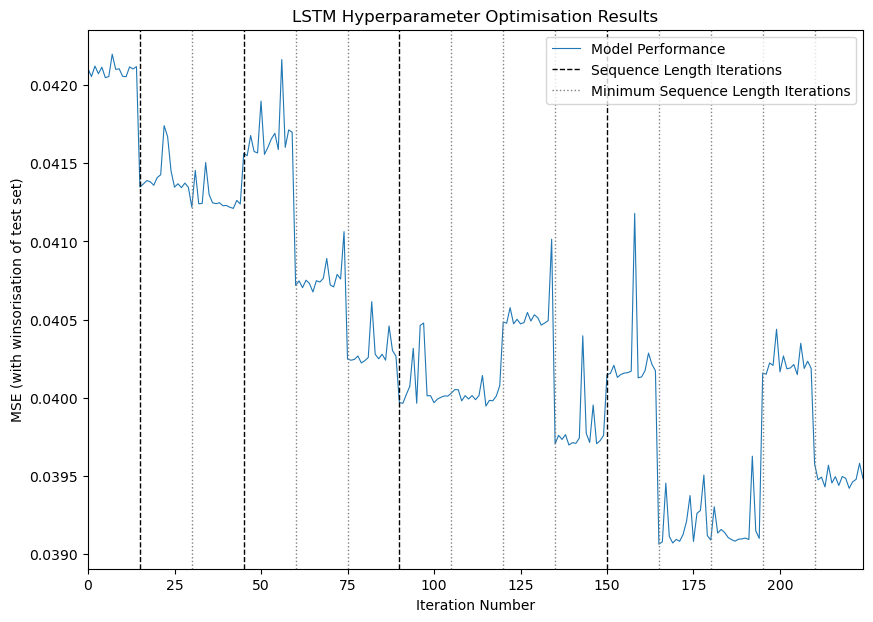

In [30]:
def cumulative_sum(n):
    total_sum = 0
    for i in range(1, n + 1):
        total_sum += i
    return total_sum

plt.figure(figsize=(10, 7))
plt.margins(x=0)
plt.plot(performance_list, linewidth=0.8, label='Model Performance')
acc = 0
for i in range(1, 5):
    if i == 1:
        label = 'Sequence Length Iterations'
    else:
        label = None
    plt.axvline(x=cumulative_sum(i) * 15, linestyle='--', linewidth=1, color='k', label=label)
for j in range(1, 15):
    if j*15 in [15, 45, 90, 150]:
        pass
    else:
        if j == 2:
            label = 'Minimum Sequence Length Iterations'
        else:
            label = None
        plt.axvline(x=j*15, linestyle=':', linewidth=1, color='grey', label=label)
plt.ylabel('MSE (with winsorisation of test set)')
plt.title('LSTM Hyperparameter Optimisation Results')
plt.xlabel('Iteration Number')
plt.legend(loc='best')

Green dashed lines represent changes in sequence length and grey dotted lines represent changes in the minimum length. Any changes in-between are due to changes in model structure.

Due to computationaly complexity, it was not possible to do k-fold cross validation, which would have been helpful in improving the robustness of results. It can be seen though that the best model performance was attained with sequence length equal to 5 and minimum length equal to either 2 or 3. There appears to be very little difference between the performance of models with different internal structure (number of layers and hidden units). Therefore, in favour of choosing the simplest model, a model with just one hidden layer and 10 hidden units in each layer is chosen for testing and a sequence length of 5 with minimum length 2.

# Simulation

In [41]:
df['public_date'] = pd.to_datetime(df['public_date'])
df_q = df[df['public_date'].dt.month.isin([12, 3, 6, 9])]
df_q = df_q.reset_index()

wins_columns = ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield']

features_pattern = "[0-9a-zA-Z]+[_]*[0-9a-zA-Z]*[_]*[a-zA-Z]*"
target= '1yr_return'
sequence_start_date = '1971-12-31'
sequence_length_years = 5
min_length_years = 2

NameError: name 'df' is not defined

In [42]:
def get_portfolio_return(y_actual, y_pred, num_stocks=30):
    return np.mean(y_actual[y_pred.argsort()[-num_stocks:].tolist()])

def common_member(a, b):
    return list(np.intersect1d(a, b))

def run_model(start_yr=1981, restriction=False):
    
    if restriction == False:
        allowed_caps = ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']
    else:
        allowed_caps = ['Mid Cap', 'Large Cap', 'Mega Cap']

    for year in range(start_yr, 2022, 1):

        test_results = pd.DataFrame(columns=['prediction_yr', 'ret_mkt_avg', 'ret_30', 'ret_50', 'ret_100', 'ret_150', 'ret_200', 'mse'])

        prediction_yr = f'{year}-12-31'
        train_end_yr = f'{int(prediction_yr[:4]) - 1}-12-31'

        rf = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_Mi_{year}.csv')
        features = re.findall(features_pattern, rf['top_features'][0])[-15:]
        print(features)
        ft_wins = common_member(features, wins_columns)

        df_train, df_test, train_start_index, train_y_idx, test_gvkey_index, norm_parameters = preprocess_data(df=df_q,
                                                            features=features,
                                                            ft_wins=ft_wins,
                                                            target=target,
                                                            sequence_start_date=sequence_start_date,
                                                            prediction_yr=prediction_yr,
                                                            train_end_yr=train_end_yr,
                                                            sequence_length_years=sequence_length_years,
                                                            min_length_years=min_length_years,
                                                            param_optim=False,
                                                            restriction=restriction
                                                            )
        
        

        train_dataset = LSTMTrainDataset(df=df_train,
                                target=target,
                                features=features,
                                sequence_length_years=sequence_length_years,
                                start_index=train_start_index,
                                y_idx=train_y_idx)

        print(train_dataset.df_[train_dataset.df_.index.isin(train_y_idx)].cap.unique())
        
        test_dataset = LSTMTestDataset(df=df_test,
                                   target=target,
                                   features=features,
                                   sequence_length_years=sequence_length_years,
                                   sequence_end_date=prediction_yr,
                                   gvkey_index=test_gvkey_index)
        
        print(test_dataset.df_[test_dataset.df_.public_date == pd.to_datetime(prediction_yr)].cap.unique())

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

        learning_rate = 5e-5
        num_hidden_units = 10
        num_layers = 1

        model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units, num_layers=num_layers)
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print()
        print(train_dataset.__len__())
        epochs = int(8 + train_dataset.__len__()/100000)
        for ix_epoch in range(epochs):
            print(f"Epoch {ix_epoch}\nlr = {optimizer.param_groups[0]['lr']}\n---------")
            train_model(train_loader, model, loss_function, optimizer=optimizer)
            test_model(test_loader, model, loss_function)
            print()

        test_output_norm = predict(test_loader, model).numpy()

        ytest = df_q[np.logical_and(df_q["public_date"] == pd.to_datetime(prediction_yr), df_q.cap.isin(allowed_caps))][target].to_numpy()
        ytest_pred, avg_return, mse = process_output(df_q, test_output_norm, prediction_yr=prediction_yr, norm_parameters=norm_parameters, restriction=restriction)

        test_results.loc[0, 'prediction_yr'] = prediction_yr
        test_results.loc[0, 'ret_mkt_avg'] = avg_return
        for num_stocks in [30, 50, 100, 150, 200]:
            test_results.loc[0, f'ret_{num_stocks}'] = get_portfolio_return(ytest, ytest_pred, num_stocks)
        test_results.loc[0, 'mse'] = mse
        raw_test_output = pd.DataFrame({'ytest_pred_raw': ytest_pred})
        print(f'Market Return: {avg_return}, Top 30 Return: {get_portfolio_return(ytest, ytest_pred, 30)}')
        
        if restriction == False:
            wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/lstm_test_results/lstm_results_{year}.csv', index=False)
            wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/lstm_test_results/lstm_results_{year}_raw.csv', index=False)
        else:
            wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/lstm_test_results/cap_limit_results/lstm_results_Mi_{year}.csv', index=False)
            wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/lstm_test_results/cap_limit_results/lstm_results_Mi_{year}_raw.csv', index=False)
        
        print(f'DONE: {year}')

Let's first run it with no market cap restrictions...

In [43]:
run_model(restriction=False)

NameError: name 'features_pattern' is not defined

Now let's run the model with restriction = True for restricting the investment universe to mid-cap+ stocks.

In [ ]:
run_model(restriction=True)

['MthCap', 'GProf', 'opmad', 'ptpm', 'debt_capital', 'debt_assets', 'cash_lt', 'pcf', '1yr_inf_rate', 'ps', 'FEDFUNDS', 'DGS10', '1yr_GDP', 'bm', 'ptb']
Train data index selection DONE. Time taken: 4455.806697368622
Test data index selection DONE. Time taken: 43.103739738464355
Data winsorised, normalised and missing data replaced DONE. Time taken: 1.2069411277770996
['Large Cap' 'Mid Cap' 'Mega Cap']
['Mid Cap' 'Large Cap' 'Mega Cap']

Epoch 0
lr = 5e-05
---------
Train loss: 0.04919607356742276
Test loss: 0.04255798994022053

Epoch 1
lr = 5e-05
---------
Train loss: 0.03256139108048276
Test loss: 0.03494959987353447

Epoch 2
lr = 5e-05
---------
Train loss: 0.02973106380493244
Test loss: 0.032128907090356186

Epoch 3
lr = 5e-05
---------
Train loss: 0.02905425072734325
Test loss: 0.03139564960242011

Epoch 4
lr = 5e-05
---------
Train loss: 0.02883393709204592
Test loss: 0.03036309332521849

Epoch 5
lr = 5e-05
---------
Train loss: 0.02869562479166976
Test loss: 0.029967061742100606


DONE: 2021
